In [99]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline, Chronos2Pipeline, ChronosPipeline

# Check CUDA availability
print("="*60)
print("CUDA INFORMATION")
print("="*60)
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"    Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"    Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
print("="*60)

# Set GPU if available (use GPU 0 by default, which is most common)
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = "cuda:0"
else:
    device = "cpu"
    print("WARNING: CUDA not available, using CPU. Inference will be slower.")

# Load the Chronos-2 pipeline
print(f"\nLoading Chronos-2 pipeline on {device}...")
pipeline: ChronosPipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-2", 
    device_map=device,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32  # Use FP16 on GPU for speed
)

print(f"✓ Chronos-2 pipeline loaded successfully on {device}!")

# Verify model is on correct device
if hasattr(pipeline, 'model'):
    model_device = next(pipeline.model.parameters()).device
    print(f"Model device: {model_device}")

%load_ext autoreload
%autoreload 2


CUDA INFORMATION
CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1
  GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design
    Memory Allocated: 2.09 GB
    Memory Cached: 2.62 GB

Loading Chronos-2 pipeline on cuda:0...
✓ Chronos-2 pipeline loaded successfully on cuda:0!
Model device: cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
# Example: Generate a sample trajectory using your project's data generation
# Or load from existing data

# Option 1: Generate synthetic trajectory
from src.dataset.dataset_configurations import default_config, generate_dataset

cfg = default_config(dim=2)
# Generate fewer trajectories for quick testing
cfg.classes[0].n_trajectories = 1  # Just 1 trajectory for demonstration
data = generate_dataset(cfg)

# Get the first trajectory (noisy measurements)
trajectory = data['X'][0]  # Shape: (T, 2) for 2D position
true_trajectory = data['Y'][0]  # Shape: (T, 2) clean ground truth

print(f"Trajectory shape: {trajectory.shape}")
print(f"Number of timesteps: {trajectory.shape[0]}")
print(f"Dimensions: {trajectory.shape[1]}")

# Option 2: Or load from your own data file
# trajectory = np.load('your_trajectory_data.npy')  # Shape should be (T, n_features)


Trajectory shape: (98, 2)
Number of timesteps: 98
Dimensions: 2


## Prepare Data for Chronos-2

**Important workflow:**
- Chronos receives **NOISY observations** (what sensors measure)
- Chronos predicts the next **NOISY observation**
- After prediction, we feed back the true **NOISY observation** (not prediction)
- Errors are calculated against **CLEAN ground truth** data

This mimics real tracking: sensors give noisy data, but we evaluate against true positions.


In [95]:
# For multi-dimensional trajectory, we'll forecast each dimension separately
# Let's start with X dimension (dimension 0)

dt = cfg.dt  # Time step from config
T = trajectory.shape[0]

# NOISY observations - what Chronos receives (simulates sensor measurements)
x_positions_noisy = trajectory[:, 0]  # First dimension (X coordinate) - NOISY

# CLEAN ground truth - what we use for error calculation
x_positions_clean = true_trajectory[:, 0]  # Clean X coordinate

# Create DataFrame for Chronos-2 with NOISY observations
timestamps = pd.date_range(start='2025-01-01', periods=T, freq=f'{dt}S')

df_observed = pd.DataFrame({
    'item_id': ['trajectory_1'] * T,  # Required: unique ID for each time series
    'timestamp': timestamps,
    'target': x_positions_noisy  # Chronos sees NOISY data
})

# Also store clean data for error calculation
df_clean = pd.DataFrame({
    'item_id': ['trajectory_1'] * T,
    'timestamp': timestamps,
    'target': x_positions_clean  # Ground truth for evaluation
})

print("="*60)
print("DATA PREPARATION")
print("="*60)
print(f"Total timesteps: {len(df_observed)}")
print(f"\nNOISY observations (what Chronos sees):")
print(df_observed.head(5))
print(f"\nCLEAN ground truth (for error calculation):")
print(df_clean.head(5))
print(f"\nNoise level: {np.std(x_positions_noisy - x_positions_clean):.4f}")


DATA PREPARATION
Total timesteps: 98

NOISY observations (what Chronos sees):
        item_id               timestamp     target
0  trajectory_1 2025-01-01 00:00:00.000  34.812018
1  trajectory_1 2025-01-01 00:00:00.040  34.819267
2  trajectory_1 2025-01-01 00:00:00.080  36.158301
3  trajectory_1 2025-01-01 00:00:00.120  37.162966
4  trajectory_1 2025-01-01 00:00:00.160  37.593187

CLEAN ground truth (for error calculation):
        item_id               timestamp     target
0  trajectory_1 2025-01-01 00:00:00.000  33.981378
1  trajectory_1 2025-01-01 00:00:00.040  34.946383
2  trajectory_1 2025-01-01 00:00:00.080  35.909806
3  trajectory_1 2025-01-01 00:00:00.120  36.872378
4  trajectory_1 2025-01-01 00:00:00.160  37.843633

Noise level: 0.3653


C:\Users\ariel\AppData\Local\Temp\ipykernel_13212\864269817.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start='2025-01-01', periods=T, freq=f'{dt}S')


## Multivariate Forecasting (Joint X-Y Prediction) - not batched


In [102]:
# Multivariate forecasting: Predict X and Y TOGETHER

if trajectory.shape[1] == 2:
    print("="*60)
    print("MULTIVARIATE FORECASTING (Joint X-Y Prediction)")
    print("="*60)
    
    # Prepare multivariate DataFrame with BOTH dimensions
    timestamps_mv = pd.date_range(start='2025-01-01', periods=T, freq=f'{dt}S')
    
    # NOISY observations for both X and Y
    df_multivar_observed = pd.DataFrame({
        'item_id': ['trajectory_2d'] * T,
        'timestamp': timestamps_mv,
        'x': trajectory[:, 0],  # X coordinate (noisy)
        'y': trajectory[:, 1]   # Y coordinate (noisy)
    })
    
    # CLEAN ground truth for both X and Y
    df_multivar_clean = pd.DataFrame({
        'item_id': ['trajectory_2d'] * T,
        'timestamp': timestamps_mv,
        'x': true_trajectory[:, 0],  # X coordinate (clean)
        'y': true_trajectory[:, 1]   # Y coordinate (clean)
    })
    
    print(f"\nMultivariate DataFrame (first 5 rows):")
    print(df_multivar_observed.head())
    
    # Iterative forecasting with MULTIPLE targets
    context_length_mv = 3
    predictions = []
    
    print(f"\nStarting joint X-Y forecasting (context={context_length_mv})...")
    print("This predicts X and Y simultaneously, capturing their correlations!\n")
    
    import time
    start_time_mv = time.time()
    
    # OPTIMIZATION: Use torch.inference_mode() for faster inference
    with torch.inference_mode():
        for i in range(context_length_mv, len(df_multivar_observed)):
            # Context includes BOTH X and Y history
            context_df = df_multivar_observed.iloc[:i].copy()
            
            # Predict BOTH X and Y together!
            pred_df = pipeline.predict_df(
                context_df,
                prediction_length=1,
                quantile_levels=[],  # Empty = only get mean prediction (faster)
                id_column='item_id',
                timestamp_column='timestamp',
                target=['x', 'y']  # ← MULTIPLE TARGETS!
            )
            
            # Extract predictions for both dimensions
            # pred_df will have columns like 'x[0.5]' and 'y[0.5]'
            predictions.append(pred_df['predictions'].values)
            
            # Progress indicator every 10 steps (reduce print overhead)
            print(f"Progress: {i - context_length_mv + 1}/{len(df_multivar_observed) - context_length_mv} ")
            
    multivar_results = {
        'predictions': predictions,
        'observed': data["X"][0],
        'real': data["Y"][0]
    }
else:
    print("Skipping multivariate forecasting (need 2D trajectory)")


MULTIVARIATE FORECASTING (Joint X-Y Prediction)

Multivariate DataFrame (first 5 rows):
         item_id               timestamp          x          y
0  trajectory_2d 2025-01-01 00:00:00.000  34.812018  54.918259
1  trajectory_2d 2025-01-01 00:00:00.040  34.819267  56.062238
2  trajectory_2d 2025-01-01 00:00:00.080  36.158301  56.517204
3  trajectory_2d 2025-01-01 00:00:00.120  37.162966  57.437793
4  trajectory_2d 2025-01-01 00:00:00.160  37.593187  57.938605

Starting joint X-Y forecasting (context=3)...
This predicts X and Y simultaneously, capturing their correlations!


C:\Users\ariel\AppData\Local\Temp\ipykernel_13212\1882983810.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_mv = pd.date_range(start='2025-01-01', periods=T, freq=f'{dt}S')


Progress: 1/95 



KeyboardInterrupt



## Batched Prediction ##

In [113]:
## 🎯 OPTIMAL: Multi-Trajectory Rolling Forecast with Batching

# This approach batches ACROSS trajectories while maintaining rolling forecast

print("="*60)
print("MULTI-TRAJECTORY ROLLING FORECAST (BATCHED)")
print("="*60)

# Generate multiple trajectories
n_trajectories = 100
cfg_multi = default_config(dim=2)
cfg_multi.classes[0].n_trajectories = n_trajectories
data_multi = generate_dataset(cfg_multi)

print(f"\nProcessing {n_trajectories} trajectories with rolling forecast")
print(f"Trajectory shape: {data_multi['X'][0].shape}")

context_length_rolling = 3
T_rolling = data_multi['X'][0].shape[0]
n_predictions = T_rolling - context_length_rolling

# Storage for all predictions
all_predictions = []

import time
start_rolling = time.time()

# Rolling forecast: iterate through timesteps, batch across trajectories
with torch.inference_mode():
    for step in range(context_length_rolling, T_rolling):
        start_step = time.time()
        # Prepare contexts for ALL trajectories at THIS timestep
        contexts_this_step = []
        
        for traj_idx in range(n_trajectories):
            trajectory_data = data_multi['X'][traj_idx]
            
            # Context: all data up to current step
            context_data = trajectory_data[:step]
            timestamps = pd.date_range(start='2025-01-01', periods=step, freq='40ms')
            
            df_context = pd.DataFrame({
                'item_id': [f'traj_{traj_idx}'] * step,
                'timestamp': timestamps,
                'x': context_data[:, 0],
                'y': context_data[:, 1]
            })
            
            contexts_this_step.append(df_context)
        
        # Combine all trajectory contexts for this timestep
        combined_contexts = pd.concat(contexts_this_step, ignore_index=True)
        
        # ONE batch prediction for all trajectories at this timestep
        pred_df = pipeline.predict_df(
            combined_contexts,
            prediction_length=1,
            quantile_levels=[],
            id_column='item_id',
            timestamp_column='timestamp',
            target=['x', 'y']
        )
        
        # Store predictions
        all_predictions.append(pred_df)
        
        # Progress
        end_step = time.time()
        print(f"Step {step - context_length_rolling + 1}/{n_predictions} ::: time: {end_step - start_step}")

elapsed_rolling = time.time() - start_rolling

print(f"\n{'='*60}")
print(f"RESULTS")
print(f"{'='*60}")
print(f"Total time: {elapsed_rolling:.2f}s")
print(f"Time per step (batched across {n_trajectories} traj): {elapsed_rolling/n_predictions:.3f}s")
print(f"Effective time per trajectory-step: {elapsed_rolling/(n_predictions*n_trajectories):.3f}s")
print(f"\n🚀 Speedup: If done sequentially: {n_predictions * n_trajectories * 10:.0f}s")
print(f"   With batching: {elapsed_rolling:.0f}s")
print(f"   Speedup factor: ~{(n_predictions * n_trajectories * 10)/elapsed_rolling:.1f}x")


MULTI-TRAJECTORY ROLLING FORECAST (BATCHED)

Processing 100 trajectories with rolling forecast
Trajectory shape: (100, 2)
Step 1/97 ::: time: 11.240724086761475
Step 2/97 ::: time: 10.374692678451538
Step 3/97 ::: time: 10.329909324645996
Step 4/97 ::: time: 10.269567966461182
Step 5/97 ::: time: 10.400842905044556
Step 6/97 ::: time: 10.290892124176025
Step 7/97 ::: time: 10.289558172225952
Step 8/97 ::: time: 10.3591947555542
Step 9/97 ::: time: 10.344953536987305
Step 10/97 ::: time: 10.346070766448975
Step 11/97 ::: time: 10.425449848175049
Step 12/97 ::: time: 10.411818027496338
Step 13/97 ::: time: 10.449539184570312
Step 14/97 ::: time: 10.377052783966064
Step 15/97 ::: time: 15.594170570373535
Step 16/97 ::: time: 10.320175409317017
Step 17/97 ::: time: 10.391122817993164
Step 18/97 ::: time: 10.247501134872437
Step 19/97 ::: time: 10.270479917526245
Step 20/97 ::: time: 10.25112009048462
Step 21/97 ::: time: 10.26418399810791
Step 22/97 ::: time: 10.440377712249756
Step 23/97 

In [114]:
## 📦 Parse Batch Predictions into KF-Compatible Format

# Convert the batch predictions into list of numpy arrays (T, 2) per trajectory
# This matches the format you need for comparison with Kalman Filter

print("="*60)
print("PARSING BATCH PREDICTIONS")
print("="*60)

# all_predictions is a list of DataFrames, one per timestep
# Each DataFrame contains predictions for ALL trajectories at that timestep

print(f"\nRaw predictions: {len(all_predictions)} timesteps")
print(f"Example prediction DataFrame:")
print(all_predictions[0].head())

# Initialize storage: one list per trajectory
chronos_predictions_per_trajectory = [[] for _ in range(n_trajectories)]

# Parse predictions: iterate through timesteps
for step_idx, step_predictions in enumerate(all_predictions):
    # step_predictions is a DataFrame with one row per trajectory
    # Each row has: item_id, timestamp, predictions
    
    for traj_idx in range(n_trajectories):
        item_id = f'traj_{traj_idx}'
        
        # Find this trajectory's prediction in this timestep
        traj_row = step_predictions[step_predictions['item_id'] == item_id]
        
        if len(traj_row) > 0:
            # Extract [x, y] prediction
            pred_xy = traj_row['predictions'].values  # Shape: (2,) for [x, y]
            chronos_predictions_per_trajectory[traj_idx].append(pred_xy)

# Convert lists to numpy arrays
chronos_predictions_per_trajectory = [
    np.array(preds) for preds in chronos_predictions_per_trajectory
]

print(f"\n✓ Parsed predictions into {len(chronos_predictions_per_trajectory)} trajectory arrays")

# Verify the format
print(f"\nFormat verification:")
for traj_idx, preds in enumerate(chronos_predictions_per_trajectory):
    print(f"  Trajectory {traj_idx}: shape {preds.shape} (expected: ({n_predictions}, 2))")
    print(f"    First 3 predictions:")
    print(f"      {preds[:3]}")

# This is now ready for comparison with KF!
print(f"\n{'='*60}")
print(f"READY FOR KALMAN FILTER COMPARISON")
print(f"{'='*60}")
print(f"Variable: chronos_predictions_per_trajectory")
print(f"Format: List of {n_trajectories} numpy arrays")
print(f"Each array shape: ({n_predictions}, 2) for [x, y] predictions")
print(f"\nExample usage:")
print(f"  chronos_predictions_per_trajectory[0]  # First trajectory predictions")
print(f"  chronos_predictions_per_trajectory[0].shape  # Should be ({n_predictions}, 2)")


PARSING BATCH PREDICTIONS

Raw predictions: 97 timesteps
Example prediction DataFrame:
  item_id               timestamp target_name  predictions
0  traj_0 2025-01-01 00:00:00.120           x     5.464844
1  traj_0 2025-01-01 00:00:00.120           y   -43.343750
2  traj_1 2025-01-01 00:00:00.120           x    35.812500
3  traj_1 2025-01-01 00:00:00.120           y    56.187500
4  traj_2 2025-01-01 00:00:00.120           x   -79.437500

✓ Parsed predictions into 100 trajectory arrays

Format verification:
  Trajectory 0: shape (97, 2) (expected: (97, 2))
    First 3 predictions:
      [[  5.4648438 -43.34375  ]
 [  4.59375   -41.5625   ]
 [  4.390625  -41.34375  ]]
  Trajectory 1: shape (97, 2) (expected: (97, 2))
    First 3 predictions:
      [[35.8125  56.1875 ]
 [37.96875 58.21875]
 [38.21875 60.90625]]
  Trajectory 2: shape (97, 2) (expected: (97, 2))
    First 3 predictions:
      [[-7.9437500e+01  4.5996094e-01]
 [-7.9812500e+01 -2.5927734e-01]
 [-7.8625000e+01 -2.8533936e-03]]

In [129]:
## 🔬 Compare Chronos with Kalman Filter

# Run KF on the same trajectories and compare MSE

print("="*60)
print("KALMAN FILTER COMPARISON")
print("="*60)

# Import KF
from src.filters.cv_kalman_filter import CVKalmanFilter, InitializationData

# Get noise parameters from the first trajectory's metadata
NOISE = np.array(data_multi["meta"][0]["params"]["measurement_noise_std"])
#NOISE = np.array([0.001, 0.001])
PROCESS_NOISE_STD = np.array(data_multi["meta"][0]["params"]["vel_change_std"])
#PROCESS_NOISE_STD = np.array([0.001, 0.001])
dt = cfg_multi.dt
initial_velocity = np.array(data_multi["meta"][0]["initial_state"]["velocity"])

# Initialize KF
initial_matrices_data = InitializationData(
    observation_noise_std=NOISE, 
    process_noise_std=PROCESS_NOISE_STD
)

kf = CVKalmanFilter(2, 4, 2, dt, initial_matrices_data)

# Run KF on all trajectories
kf_predictions_per_trajectory = []
kf_mse_per_trajectory = []

print(f"\nRunning Kalman Filter on {n_trajectories} trajectories...")

for traj_idx in range(n_trajectories):
    # Get initial state
    initial_position = data_multi["X"][traj_idx][0]
    x0 = np.array([initial_position[0], initial_velocity[0], 
                   initial_position[1], initial_velocity[1]])
    P0 = np.eye(4) * 1e1
    
    # Run KF with k=1 lag (1-step ahead prediction)
    kf.initialize(x0, P0)
    mse_kf, preds_kf = kf.run_k_lag(
        measurements=data_multi["X"][traj_idx],
        X0=x0,
        P0=P0,
        k=1,
        clean_signal=data_multi["Y"][traj_idx],
        normalize_mse=False
    )    
    # Store results (note: KF returns predictions starting from k+1)
    # We need to align with Chronos predictions which start from context_length_rolling
    kf_predictions_per_trajectory.append(preds_kf)
    kf_mse_per_trajectory.append(mse_kf)
    
    print(f"  Trajectory {traj_idx}: KF MSE = {mse_kf:.6f}")

# Calculate Chronos MSE for comparison
chronos_mse_per_trajectory = []

print(f"\nCalculating Chronos MSE...")

for traj_idx in range(n_trajectories):
    # Get ground truth (clean signal)
    clean_truth = data_multi["Y"][traj_idx][context_length_rolling:]
    chronos_preds = chronos_predictions_per_trajectory[traj_idx]
    
    # Calculate MSE
    mse_chronos = ((clean_truth - chronos_preds)**2).mean()
    chronos_mse_per_trajectory.append(mse_chronos)
    
    print(f"  Trajectory {traj_idx}: Chronos MSE = {mse_chronos:.6f}")

# Summary comparison
print(f"\n{'='*60}")
print(f"COMPARISON SUMMARY")
print(f"{'='*60}")

avg_kf_mse = np.mean(kf_mse_per_trajectory)
avg_chronos_mse = np.mean(chronos_mse_per_trajectory)

print(f"\nAverage MSE across {n_trajectories} trajectories:")
print(f"  Kalman Filter: {avg_kf_mse:.6f}")
print(f"  Chronos-2:     {avg_chronos_mse:.6f}")

if avg_chronos_mse < avg_kf_mse:
    improvement = ((avg_kf_mse - avg_chronos_mse) / avg_kf_mse) * 100
    print(f"\n✓ Chronos is {improvement:.1f}% better than KF")
else:
    improvement = ((avg_chronos_mse - avg_kf_mse) / avg_kf_mse) * 100
    print(f"\n✗ KF is {improvement:.1f}% better than Chronos")

print(f"\nPer-trajectory breakdown:")
counter_chronus_wins = 0
for traj_idx in range(n_trajectories):
    kf_mse = kf_mse_per_trajectory[traj_idx]
    chronos_mse = chronos_mse_per_trajectory[traj_idx]
    counter_chronus_wins += 1 if chronos_mse < kf_mse else 0
    winner = "Chronos" if chronos_mse < kf_mse else "KF"
    print(f"  Traj {traj_idx}: KF={kf_mse:.6f}, Chronos={chronos_mse:.6f} → {winner} wins")

print(f"Chronus perecnt: {counter_chronus_wins / n_trajectories}")

KALMAN FILTER COMPARISON

Running Kalman Filter on 100 trajectories...
  Trajectory 0: KF MSE = 0.044607
  Trajectory 1: KF MSE = 0.088828
  Trajectory 2: KF MSE = 0.125593
  Trajectory 3: KF MSE = 0.043440
  Trajectory 4: KF MSE = 0.037920
  Trajectory 5: KF MSE = 0.144522
  Trajectory 6: KF MSE = 0.060634
  Trajectory 7: KF MSE = 0.049230
  Trajectory 8: KF MSE = 0.045703
  Trajectory 9: KF MSE = 0.038664
  Trajectory 10: KF MSE = 0.087643
  Trajectory 11: KF MSE = 0.054078
  Trajectory 12: KF MSE = 0.081906
  Trajectory 13: KF MSE = 0.040412
  Trajectory 14: KF MSE = 0.064600
  Trajectory 15: KF MSE = 0.095411
  Trajectory 16: KF MSE = 0.112512
  Trajectory 17: KF MSE = 0.038515
  Trajectory 18: KF MSE = 0.040442
  Trajectory 19: KF MSE = 0.100302
  Trajectory 20: KF MSE = 0.101013
  Trajectory 21: KF MSE = 0.044736
  Trajectory 22: KF MSE = 0.058854
  Trajectory 23: KF MSE = 0.111674
  Trajectory 24: KF MSE = 0.055175
  Trajectory 25: KF MSE = 0.063994
  Trajectory 26: KF MSE = 0.0

0.058651668510812646


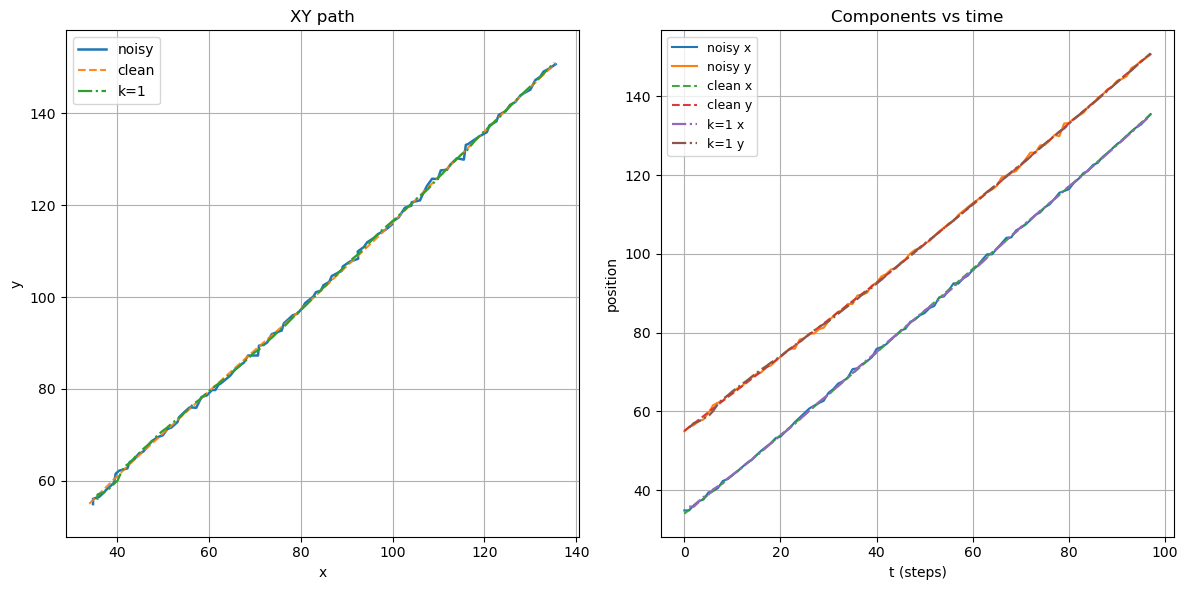

In [64]:
from src.filters.cv_kalman_filter import CVKalmanFilter, InitializationData
from src.motion_models.trajectory_generation.route_generation import TrajectoryState, generate_cv_trajectory

a = data
NOISE = np.array(data["meta"][0]["params"]["measurement_noise_std"])
PROCESS_NOISE_STD = np.array(data["meta"][0]["params"]["vel_change_std"])
dt=0.04
initial_velocity = np.array(data["meta"][0]["initial_state"]["velocity"])
initial_position = np.array(data["meta"][0]["initial_state"]["position"])

# Initialzing the KF
initial_matrices_data = InitializationData(observation_noise_std=NOISE, process_noise_std=PROCESS_NOISE_STD)

base_kf = CVKalmanFilter(2, 4, 2, dt, initial_matrices_data)
x0 = np.array([data["X"][0][0][0], initial_velocity[0], data["X"][0][0][1], initial_velocity[1]])
P0 = np.eye(4) * 1e2
base_kf.initialize(x0, P0)

mse_k1, preds_k1= base_kf.run_k_lag(
            measurements=data["X"][0],
            X0=x0,
            P0=P0,
            k=1,
            clean_signal=data["Y"][0],
            normalize_mse=False
        )

#mse_k1 = ((data["Y"][0][3:] - preds_k1[2:])**2).mean()
print(mse_k1)

plot_trajectories_with_predictions_shifted(data["X"][0], data["Y"][0], [(preds_k1, 1)])